In [1]:
import networkx as nx
from networkx.algorithms import community
import itertools
from random import shuffle

In [2]:
def read_graph(path):
    '''
    读取输入的交易信息
    格式为：结点1,结点2
    英文逗号分格，无空行
    返回一个字典：如{'a': {'b': 1, 'c': 1, 'd': 1, 'e': 1}, 'c': {'b': 1}, 'b': {'c': 1, 'd': 1}, 'e': {'d': 1, 'b': 1}, 'd': {'a': 1}}
    '''
    graph_dict = {}
    with open(path, 'r') as f:
        for line in f.readlines():
            line = line.strip('\n').split(',')
            try:
                graph_dict[line[0]][line[1]] += 1
            except:
                try:
                    graph_dict[line[0]][line[1]] = 1
                except:
                    graph_dict[line[0]] = {}
                    graph_dict[line[0]][line[1]] = 1    
    return graph_dict

In [3]:
def gen_graph(graph_dict):
    '''
    根据读取的交易数据构造图
    权重为两个结点间交易次数
    '''
    G = nx.Graph()
    for entity in graph_dict.keys():
        for relation in graph_dict[entity]:
            weight = graph_dict[entity][relation]
            # 统计双方互相的交易总数
            try:
                weight += graph_dict[relation][entity]
            except:
                pass
            G.add_edge(entity, relation, weight=weight)
    return G

In [4]:
def girvan_newman(G, most_valuable_edge=None):
    """
    Finds communities in a graph using the Girvan–Newman method.
    @Parameters
    G : NetworkX graph
    most_valuable_edge : function
        接收图作为输入，输出一条边，边可以在算法的迭代过程中计算，如果没有指定，则选取edge_betweenness_centrality
    @Return
    返回迭代器，可以通过迭代器得到具体分组

    """
    # 如果图是空的，则返回
    if G.number_of_edges() == 0:
        yield tuple(nx.connected_components(G))
        return
    # 如果没有提供函数作为参数，则默认选用edge_betweenness_centrality
    if most_valuable_edge is None:
        def most_valuable_edge(G):
            # 这时图一定不为空
            betweenness = nx.edge_betweenness_centrality(G)
            return max(betweenness, key=betweenness.get)
    # 复制原图为无向图
    g = G.copy().to_undirected()
    # 移去某条边，看看是否会造成影响
    g.remove_edges_from(nx.selfloop_edges(g))
    while g.number_of_edges() > 0:
        yield _without_most_central_edges(g, most_valuable_edge)



def _without_most_central_edges(G, most_valuable_edge):
    """
    通过不停移除某条最有价值的边来得到分区
    G必须非空
    """
    original_num_components = nx.number_connected_components(G)
    num_new_components = original_num_components
    while num_new_components <= original_num_components:
        edge = most_valuable_edge(G)
        G.remove_edge(*edge)
        new_components = tuple(nx.connected_components(G))
        num_new_components = len(new_components)
    return new_components

In [5]:
def most_central_edge(G):
    '''
    按照边权重的介中心性来区分社区
    '''
    centrality = nx.edge_betweenness_centrality(G, weight='weight')
#     centrality = nx.eigenvector_centrality_numpy(G, weight='weight')
#     centrality = nx.information_centrality(G, weight='weight')
    return max(centrality, key=centrality.get)

In [6]:
def detect_communities(G):
    '''
    输入图
    返回社区
    '''
    comp = girvan_newman(G, most_valuable_edge=most_central_edge)
    group = tuple(sorted(c) for c in next(comp))
    group_dict = {}
    for i in range(len(group)):
        for node in group[i]:
            group_dict[node] = i
    return group_dict

In [7]:
def flow_between_communities(G, group):
    # 分区间交流
    between_sum = 0
    # 分区内交流
    in_sum = 0
    for edge in G.edges:
        try:
            if group[edge[0]] != group[edge[1]]:
                between_sum += G[edge[0]][edge[1]]['weight']
            else:
                in_sum += G[edge[0]][edge[1]]['weight']
        except:
            # 否则说明有新边加入，则直接加权
            between_sum += G[edge[0]][edge[1]]['weight']
    return between_sum, in_sum


In [8]:
# # def shuffle_group(G):
# shuffle()

def shuffle_group(G, k):
    '''
    将途中结点随机等分为k组
    '''
    nodes = list(G.nodes)
    shuffle(nodes)
    m = int(len(nodes)/k)
    group = []
    for i in range(0, len(nodes), m):
        group.append(nodes[i:i+m])
    group_dict = {}
    for i in range(len(group)):
        for node in group[i]:
            group_dict[node] = i
    return group_dict

In [9]:
day1_data = 'day1'
day1_data = read_graph(day1_data)
G1 = gen_graph(day1_data)

day2_data = 'day2'
day2_data = read_graph(day2_data)
G2 = gen_graph(day2_data)

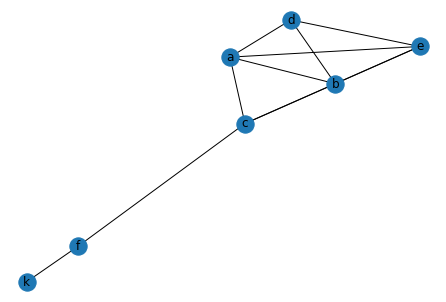

In [10]:
nx.draw(G1, with_labels=True)

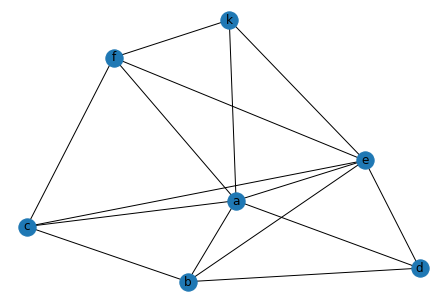

In [11]:
nx.draw(G2, with_labels=True)

In [12]:
# 已经实现的分组
group = detect_communities(G1)
group

{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': 1, 'k': 1}

In [13]:
# 打印day1中不同社区之间和社区内的交流
between_g1, in_g1 = flow_between_communities(G1, group)
# 打印day2中不同社区之间和社区内的交流
between_g2, in_g2 = flow_between_communities(G2, group)

print('区间：', between_g1, ' 区内：',in_g1)
print('区间：', between_g2, ' 区内：',in_g2)

区间： 1  区内： 43
区间： 5  区内： 39


In [14]:
# 随机分组
group = shuffle_group(G1, 2)
group

{'b': 0, 'd': 0, 'f': 0, 'c': 1, 'k': 1, 'a': 1, 'e': 2}

In [15]:
# 打印day1中不同社区之间和社区内的交流
between_g1, in_g1 = flow_between_communities(G1, group)
# 打印day2中不同社区之间和社区内的交流
between_g2, in_g2 = flow_between_communities(G2, group)

print('区间：', between_g1, ' 区内：',in_g1)
print('区间：', between_g2, ' 区内：',in_g2)

区间： 38  区内： 6
区间： 37  区内： 7
